# Analysis

1. [Import Libraries](#libraries)
    1. [Custom Functions](#functions)
2. [Import Data](#data)
    1. [Convert to DataLoader](#convert)
3. [Build Model](#model)
    1. [Hyperparameters](#hyperparameters)
    2. [MLP](#mlp)
4. [Analysis](#analysis)

## Import Libraries<a id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics

from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [4]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [5]:
import timeit
import researchpy as rp

In [6]:
%matplotlib inline

In [7]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [8]:
writer = SummaryWriter(log_dir="Analysis_v1")

## Custom Functions <a id="functions"></a>

#### Dataset class for pytorch dataloader

In [9]:
class dataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data, dtype=torch.float32, device=device)
        self.y = torch.tensor(target, dtype=torch.float32, device=device)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

#### Training function

In [10]:
def train(data, model, criterion, metric, optimizer):
    size = len(data.dataset)
    batches = len(data)
    running_loss = []
    acc = 0.0
    correct = 0
    predictions = []
    actuals = []
    loss = 0.0
    acc = 0.0
    current = 0
    
    for batch, (X, y) in enumerate(data,1):
        
        # forward step
        optimizer.zero_grad() # zero out the gradients
        y_hat = model(X)  #forward pass
        
        y = y.unsqueeze(-1) # reduce dimensions of tensor from [256, 1] to [256]
        
        loss = criterion(y_hat, y)  # calculate loss
       
        #  backprop step
        loss.backward()       # backward pass through model; computes gradients
        optimizer.step()      # update weights
        
        # metrics
        y = y.int()
        acc = metric(y_hat, y)

        y_hat = y_hat.cpu().detach().numpy()
        y_hat = y_hat.reshape(-1)
        
        y = y.cpu().detach().numpy()
        y = y.reshape(-1)
        
        predictions.append(y_hat)
        actuals.append(y)
            
        running_loss.append(loss.item())
    
        ## every 50 batches, store the results
        #if batch % 50 == 0:
        #    current = batch * len(X)
        
    print(f"\tTraining\tAccuracy: {acc:1.10f}\tLoss: {loss:1.10f}")
    
    return predictions, actuals, running_loss

#### Test function

In [11]:
def test(data, model, criterion, metric):
    size = len(data.dataset)
    batches = len(data)
    tst_loss = 0
    correct = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X, y in data:
            y_hat = model(X)
            y = y.unsqueeze(-1)
            tst_loss += criterion(y_hat, y).item()
            
            y = y.int()
            acc = metric(y_hat, y)
            
            y_hat = y_hat.cpu().detach().numpy()
            y_hat = y_hat.reshape(-1)
        
            y = y.cpu().detach().numpy()
            y = y.reshape(-1)
        
            predictions.append(y_hat)
            actuals.append(y)
            
    tst_loss /= batches
    correct /= size
    
    print(f"\tTest error\tAccuracy: {acc:1.10f}\tLoss: {tst_loss:1.10f}")
    return predictions, actuals

#### Function to flatten lists

In [12]:
def flatten(thing):
    '''
    thing: a list
    
    flatten receives a multi-level list and flatten it down 2 layers
    '''
    #thing = [element for sublist in thing for element in sublist]
    return [element for sublist in thing for element in sublist]

#### Additional Functions

In [13]:
# activation functions
elu = nn.ELU()
leaky = nn.LeakyReLU()
relu = nn.ReLU()
selu = nn.SELU()
tanh = nn.Tanh()
sigmoid = nn.Sigmoid()

# loss functions
mse = nn.MSELoss()
bce = nn.BCELoss()
kld = nn.KLDivLoss()

# optimizers
adam = torch.optim.Adam
sgd = torch.optim.SGD

#### Seed the RNG for the experiments

In [14]:
# random seed for consistency in pytorch and numpy
SEED = 23

torch.manual_seed(SEED)
np.random.seed(SEED)

#### Set device to CUDA, if available

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data<a id="data"></a>

#### Uncomment next when using google colab

In [16]:
# french_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/french.parquet?raw=true")
# adult_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/adult.parquet?raw=true")
# loans_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/loans.parquet?raw=true")

#### Use the following cell if the data is stored locally

In [17]:
french_df = pd.read_parquet("french.parquet")
adult_df = pd.read_parquet("adult.parquet")
loans_df = pd.read_parquet("loans.parquet")

#### Peak the data

##### FrenchC2C

In [18]:
french_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Columns: 224 entries, socialNbFollowers to language_it
dtypes: bool(4), float64(2), int64(218)
memory usage: 166.4 MB


In [19]:
french_df.shape

(98913, 224)

In [20]:
french_df.head()

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsMonths,target,civGen_1,civGen_2,civGen_3,gender_F,gender_M,countryCode_ad,countryCode_ae,countryCode_af,countryCode_ag,countryCode_ai,countryCode_al,countryCode_am,countryCode_an,countryCode_ao,countryCode_aq,countryCode_ar,countryCode_as,countryCode_at,countryCode_au,countryCode_aw,countryCode_az,countryCode_ba,countryCode_bb,countryCode_bd,countryCode_be,countryCode_bf,countryCode_bg,countryCode_bh,countryCode_bj,countryCode_bl,countryCode_bm,countryCode_bn,countryCode_bo,countryCode_br,countryCode_bs,countryCode_bv,countryCode_bw,countryCode_by,countryCode_bz,countryCode_ca,countryCode_cd,countryCode_cf,countryCode_cg,countryCode_ch,countryCode_ci,countryCode_cl,countryCode_cm,countryCode_cn,countryCode_co,countryCode_cr,countryCode_cu,countryCode_cy,countryCode_cz,countryCode_de,countryCode_dj,countryCode_dk,countryCode_dm,countryCode_do,countryCode_dz,countryCode_ec,countryCode_ee,countryCode_eg,countryCode_er,countryCode_es,countryCode_et,countryCode_fi,countryCode_fj,countryCode_fk,countryCode_fo,countryCode_fr,countryCode_ga,countryCode_gb,countryCode_gd,countryCode_ge,countryCode_gg,countryCode_gh,countryCode_gi,countryCode_gm,countryCode_gn,countryCode_gp,countryCode_gr,countryCode_gs,countryCode_gt,countryCode_gu,countryCode_gy,countryCode_hk,countryCode_hn,countryCode_hr,countryCode_ht,countryCode_hu,countryCode_ic,countryCode_id,countryCode_ie,countryCode_il,countryCode_im,countryCode_in,countryCode_iq,countryCode_ir,countryCode_is,countryCode_it,countryCode_je,countryCode_jm,countryCode_jo,countryCode_jp,countryCode_ke,countryCode_kg,countryCode_kh,countryCode_ki,countryCode_kn,countryCode_kp,countryCode_kr,countryCode_kw,countryCode_ky,countryCode_kz,countryCode_la,countryCode_lb,countryCode_lc,countryCode_li,countryCode_lk,countryCode_lt,countryCode_lu,countryCode_lv,countryCode_ly,countryCode_ma,countryCode_mc,countryCode_md,countryCode_mg,countryCode_mk,countryCode_ml,countryCode_mm,countryCode_mn,countryCode_mo,countryCode_mq,countryCode_mr,countryCode_mt,countryCode_mu,countryCode_mv,countryCode_mx,countryCode_my,countryCode_na,countryCode_nc,countryCode_ne,countryCode_nf,countryCode_ng,countryCode_ni,countryCode_nl,countryCode_no,countryCode_np,countryCode_nz,countryCode_om,countryCode_pa,countryCode_pe,countryCode_pf,countryCode_ph,countryCode_pk,countryCode_pl,countryCode_pr,countryCode_pt,countryCode_pw,countryCode_py,countryCode_qa,countryCode_re,countryCode_ro,countryCode_rs,countryCode_ru,countryCode_rw,countryCode_sa,countryCode_se,countryCode_sg,countryCode_si,countryCode_sj,countryCode_sk,countryCode_sn,countryCode_sr,countryCode_sv,countryCode_sy,countryCode_sz,countryCode_tc,countryCode_td,countryCode_tg,countryCode_th,countryCode_tj,countryCode_tn,countryCode_tr,countryCode_tt,countryCode_tw,countryCode_tz,countryCode_ua,countryCode_ug,countryCode_um,countryCode_us,countryCode_uy,countryCode_uz,countryCode_vc,countryCode_ve,countryCode_vg,countryCode_vi,countryCode_vn,countryCode_vu,countryCode_ws,countryCode_yt,countryCode_za,countryCode_zm,countryCode_zw,language_de,language_en,language_es,language_fr,language_it
0,147,10,77,26,174,74.0,104,1,True,False,True,True,11,106.53,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,167,8,2,19,170,99.0,0,0,True,False,True,True,12,106.80,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##### Adult Income

In [21]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Columns: 109 entries, age to target
dtypes: int64(109)
memory usage: 27.1 MB


In [22]:
adult_df.shape

(32561, 109)

In [23]:
adult_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
list(adult_df.columns)

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ ?',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Never-worked',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_ 10th',
 'education_ 11th',
 'education_ 12th',
 'education_ 1st-4th',
 'education_ 5th-6th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Assoc-acdm',
 'education_ Assoc-voc',
 'education_ Bachelors',
 'education_ Doctorate',
 'education_ HS-grad',
 'education_ Masters',
 'education_ Preschool',
 'education_ Prof-school',
 'education_ Some-college',
 'marital-status_ Divorced',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ ?',
 'occupation_ Adm-clerical',
 'occupation_ Ar

##### Loans

In [25]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ApplicantIncome           614 non-null    int64  
 1   CoapplicantIncome         614 non-null    float64
 2   LoanAmount                614 non-null    float64
 3   Loan_Amount_Term          614 non-null    float64
 4   Credit_History            614 non-null    float64
 5   Gender_-1                 614 non-null    uint8  
 6   Gender_Female             614 non-null    uint8  
 7   Gender_Male               614 non-null    uint8  
 8   Married_-1                614 non-null    uint8  
 9   Married_No                614 non-null    uint8  
 10  Married_Yes               614 non-null    uint8  
 11  Dependents_-1             614 non-null    uint8  
 12  Dependents_0              614 non-null    uint8  
 13  Dependents_1              614 non-null    uint8  
 14  Dependents

In [26]:
loans_df.shape

(614, 25)

### Convert <a id="convert"></a>

#### Split into train and test sets

In [27]:
french_X = french_df.drop(["gender_M", "target"], axis=1).values.astype(np.float32)
french_y = french_df.target.values.astype(np.float32)

In [28]:
fX_train, fX_test, fY_train, fY_test = train_test_split(french_X, french_y, test_size=0.3,
                                                        random_state=SEED, stratify=french_y)

In [29]:
fX_train.shape

(69239, 222)

In [30]:
adult_X = adult_df.drop(["sex_ Male", "target"], axis=1).values.astype(np.float32)
adult_y = adult_df.target.values.astype(np.float32)

In [31]:
loans_X = loans_df.drop("target", axis=1).values.astype(np.float32)
loans_y = loans_df.target.values.astype(np.float32)

#### Make datasets

In [32]:
french_trng_data = dataset(fX_train, fY_train)
french_test_data = dataset(fX_test, fY_test)

## Model<a id="model"></a>

#### MLP <a id="mlp"></a>

In [33]:
class MLP(nn.Module):
    
    def __init__(self, in_size, hidden1=relu, hidden2=relu, hidden3=relu, out_layer=sigmoid):
        super(MLP, self).__init__()
        
        # construct model dependent on size of inputs
        out1_2 = 2*in_size // 3
        out2_3 = 2*out1_2 // 3
        out3_4 = 2*out2_3 // 3

        self.linear_stack = nn.Sequential(
            nn.Linear(in_size, out1_2),
            hidden1,
            nn.Linear(out1_2, out2_3),
            hidden2,
            nn.Linear(out2_3, out3_4),
            hidden3,
            nn.Linear(out3_4, 1),
            out_layer
        )
        
    def forward(self, x):
        out = self.linear_stack(x)

        return out

# Experiments

### Trial 1

#### Hyperparameters <a id="hyperparameters"></a>

In [34]:
alpha = 1e-5 # 0.00001
epochs = 50
batches = 256
hidden1 = relu
hidden2 = relu
hidden3 = relu
out_layer = sigmoid

#### Construct Model

In [35]:
# instantiate model
fr_model = MLP(french_X.shape[1], hidden1, hidden2, hidden3, out_layer).to(device)

# select optimizing function
optimizer = adam(fr_model.parameters(), lr=alpha)

# select loss function
criterion = bce

# accuracy metric
metric = torchmetrics.functional.accuracy

# display model
print(fr_model.parameters)

<bound method Module.parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=222, out_features=148, bias=True)
    (1): ReLU()
    (2): Linear(in_features=148, out_features=98, bias=True)
    (3): ReLU()
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): ReLU()
    (6): Linear(in_features=65, out_features=1, bias=True)
    (7): Sigmoid()
  )
)>


#### DataLoader

In [36]:
# feeds data into pytorch neural network
fr_training_dl = DataLoader(french_trng_data, batch_size=batches)
fr_testing_dl = DataLoader(french_test_data, batch_size=batches)

#### Train and test

In [37]:
training_results = []
training_actuals = []
training_losses = []

testing_results = []
testing_actuals = []


start = timeit.default_timer()
for epoch in range(1,epochs+1):
    print (f"Epoch {epoch} / {epochs}")
    
    trng_result, trng_actual, trng_loss = train(fr_training_dl, fr_model, criterion, metric, optimizer)
    tst_result, tst_actual = test(fr_testing_dl, fr_model, criterion, metric)

    training_results.append(trng_result)
    training_actuals.append(trng_actual)
    training_losses.append(trng_loss)
    testing_results.append(tst_result)
    testing_actuals.append(tst_actual)
    
print("Finished")
print("* " * 30)
stop = timeit.default_timer()
print(f"Execution time (in seconds): {stop - start}")

Epoch 1 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2619740069
	Test error	Accuracy: 0.9829059839	Loss: 0.2020611123
Epoch 2 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2525250912
	Test error	Accuracy: 0.9786324501	Loss: 0.1724695242
Epoch 3 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2554808557
	Test error	Accuracy: 0.9786324501	Loss: 0.1693392077
Epoch 4 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2547386885
	Test error	Accuracy: 0.9829059839	Loss: 0.1678964620
Epoch 5 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2540018857
	Test error	Accuracy: 0.9829059839	Loss: 0.1668249118
Epoch 6 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2532825768
	Test error	Accuracy: 0.9829059839	Loss: 0.1659505111
Epoch 7 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2528990507
	Test error	Accuracy: 0.9829059839	Loss: 0.1652139291
Epoch 8 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2521348596
	Test error	Accuracy: 0.9829059839	Loss: 0.1644714626
Epoch 9 / 50
	Training	Accuracy: 0.9159663916	Lo

### Prepare results for analysis

In [38]:
fr_trng_preds = [[] for _ in range(len(training_results))]
fr_trng_actual = [[] for _ in range(len(training_actuals))]

fr_tst_preds = [[] for _ in range(len(testing_results))]
fr_tst_actual = [[] for _ in range(len(testing_actuals))]

In [39]:
for i in range(len(training_results)):
    fr_trng_preds[i] = flatten(training_results[i])
    fr_trng_actual[i] = flatten(training_actuals[i])
    
    fr_tst_preds[i] = flatten(testing_results[i])
    fr_tst_actual[i] = flatten(testing_actuals[i])

#### Scoring metrics

In [40]:
fr_acc_trng = []
fr_acc_tst = []
fr_loss = []
for i in range(len(fr_trng_preds)):
    trng_acc = (np.array(np.round(fr_trng_preds[i])) == np.array(fr_trng_actual[i])).sum()/len(fr_trng_preds[i])
    test_acc = (np.array(np.round(fr_tst_preds[i])) == np.array(fr_tst_actual[i])).sum()/len(fr_tst_preds[i])
    
    avg_loss = np.average(training_losses[i])
    
    fr_acc_trng.append(trng_acc)
    fr_acc_tst.append(test_acc)
    fr_loss.append(avg_loss)
    writer.add_scalar("Training Accuracy", trng_acc, i)
    writer.add_scalar("Test Accuracy", test_acc, i)
    writer.add_scalar("Training Loss", avg_loss, i)   

In [41]:
writer.close()

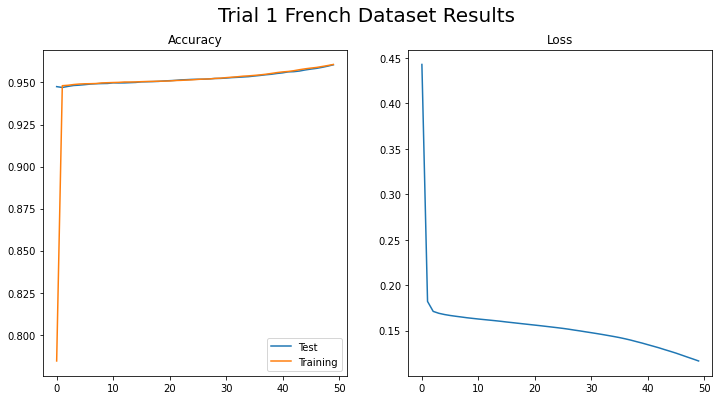

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

fig.suptitle("Trial 1 French Dataset Results", size=20)

axs[0].plot(fr_acc_tst, label="Test")
axs[0].plot(fr_acc_trng, label="Training")
axs[0].set_title("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(fr_loss)
axs[1].set_title("Loss")

plt.show()

In [43]:
len(training_losses[0])

271

In [45]:
np.round(fr_trng_preds)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
print("\t  TP\tTN\tFP\tFN")
fr_metrics = []
for n_iter, (predictions, actuals) in enumerate(list(zip(fr_trng_preds, fr_trng_actual))):
    TP, TN = 0, 0
    FP, FN = 0, 0
    for i, j in list(zip(np.round(predictions), actuals)):
        if (i == j) and (i == 1):
            TP += 1
        elif (i == j) and (i == 0):
            TN += 1
        elif (i != j) and (i == 1):
            FP += 1
        elif (i != j) and (i == 0):
            FN += 1
            
    fr_metrics.append((TP,TN,FP,FN))
    print(f"Epoch {n_iter+1:2}:{TP:5d}\t{TN:5d}\t{FP:5d}\t{FN:5d}")

	  TP	TN	FP	FN
Epoch  0: 1348	52969	12477	 2445
Epoch  1:  279	65366	   80	 3514
Epoch  2:  283	65379	   67	 3510
Epoch  3:  331	65361	   85	 3462
Epoch  4:  369	65344	  102	 3424
Epoch  5:  390	65333	  113	 3403
Epoch  6:  409	65318	  128	 3384
Epoch  7:  423	65311	  135	 3370
Epoch  8:  453	65306	  140	 3340
Epoch  9:  474	65293	  153	 3319
Epoch 10:  490	65285	  161	 3303
Epoch 11:  510	65271	  175	 3283
Epoch 12:  536	65261	  185	 3257
Epoch 13:  551	65245	  201	 3242
Epoch 14:  566	65234	  212	 3227
Epoch 15:  591	65219	  227	 3202
Epoch 16:  607	65211	  235	 3186
Epoch 17:  624	65197	  249	 3169
Epoch 18:  646	65184	  262	 3147
Epoch 19:  665	65167	  279	 3128
Epoch 20:  682	65157	  289	 3111
Epoch 21:  708	65150	  296	 3085
Epoch 22:  725	65139	  307	 3068
Epoch 23:  745	65131	  315	 3048
Epoch 24:  758	65128	  318	 3035
Epoch 25:  781	65123	  323	 3012
Epoch 26:  801	65115	  331	 2992
Epoch 27:  815	65107	  339	 2978
Epoch 28:  835	65107	  339	 2958
Epoch 29:  847	65107	  339	 

Calculate the recall, precision, etc from the above